In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Getting and transforming data

The following involoves the process of retrieving data from the ```wrds``` server and treating as such that the different data sources are merged and exported to a file named "as3_ex3_data.csv")

In [13]:
# import wrds
# db = wrds.Connection(wrds_username='hienle')
# db.create_pgpass_file()

In [14]:
# See http://www.crsp.com/files/treasury_guide_0.pdf for more infos on the CRSP Treasury risk-
# free rate database. Note that ”mcaldt” denotes the last quotation date of the relevant bond in a given month,
# i.e. the the yield corresponding to January 31 is the yield that was promised in the beginning of January.
# Note that the CRSP monthly risk-free rates are continuously compounded and annualized. Thus, you need to transform 
# them into simple and monthly rates, in order to use them in your portfolio construction (the
# stock returns are already simple monthly returns) 

# vw_ret = db.raw_sql("select date,vwretd from crsp.msi where date>='1960-01-01' and date<='2019-12-31'", 
#                           date_cols=["date"]).rename(columns={"vwretd": "ret"})
# vw_bonds = db.raw_sql("select caldt, b2ret "
# "from crsp.mcti "
# "where caldt>='1960-01-01'"
# "and caldt<='2019-12-31'", date_cols=["caldt"]).rename(columns={"caldt": "date", "b2ret": "ret"})
# tb_ret = db.raw_sql("select mcaldt, tmytm from crsp.tfz_mth_rf where kytreasnox = 2000001 and mcaldt>='1960-01-01'\
#                     and mcaldt <='2019-12-31'").rename(columns={"mcaldt": "date", "tmytm": "ret"})
# tb_ret["simp_ret"] = (np.exp(tb_ret["ret"]/12/100)-1) # de-annualise then de-compound the return

In [15]:
# # the dates recorded in the three dfs are not synchronised
# merged=pd.merge(pd.merge(vw_ret, vw_bonds, left_index=True, right_index=True), tb_ret, left_index=True, right_index=True)
# merged.to_csv("as3_ex3_data.csv")

In [43]:
data = pd.read_csv("as3_ex3_data.csv", index_col=0)

### 2. Analysing

#### 2.1. 100% risky and 100% riskless 

In [44]:
# these following two lines are redundant for now
data["excess_ret_x"] = data["ret_x"] - data["simp_ret"]
data["excess_ret_y"] = data["ret_y"] - data["simp_ret"]

In [45]:
data.head(10)

,date_x,ret_x,date_y,ret_y,date,ret,simp_ret,excess_ret_x,excess_ret_y
0,1960-01-29,-0.066244,1960-01-29,0.009443,1960-01-29,3.427324,0.002860,-0.069104,0.006583
1,1960-02-29,0.014419,1960-02-29,0.008344,1960-02-29,3.808210,0.003179,0.011241,0.005165
2,1960-03-31,-0.012822,1960-03-31,0.014125,1960-03-31,2.537828,0.002117,-0.014939,0.012008
3,1960-04-29,-0.015271,1960-04-29,-0.003661,1960-04-29,2.893542,0.002414,-0.017685,-0.006075
4,1960-05-31,0.034098,1960-05-31,0.006015,1960-05-31,2.334168,0.001947,0.032151,0.004068
5,1960-06-30,0.022833,1960-06-30,0.008191,1960-06-30,1.725013,0.001439,0.021394,0.006752
6,1960-07-29,-0.022705,1960-07-29,0.015361,1960-07-29,1.750399,0.001460,-0.024164,0.013901
7,1960-08-31,0.032215,1960-08-31,0.008301,1960-08-31,2.004431,0.001672,0.030543,0.006629
8,1960-09-30,-0.058673,1960-09-30,0.002977,1960-09-30,2.446218,0.002041,-0.060714,0.000936
9,1960-10-31,-0.004705,1960-10-31,0.000336,1960-10-31,1.521809,0.001269,-0.005974,-0.000933


In [19]:
# Compute the mean return, standard deviation and correlation matrix for these
# returns over the entire sample period. Using the 1-month T-Bill as the risk-free
# rate to compute excess returns. To compute excess returns assume that the risk-
# free rate is constant at the sample average of the T-Bill rate.

d_returns = {
    "vw_ret": data["ret_x"],
    "vw_bonds": data["ret_y"],
    #"tb_ret": tb_ret
}
summ_1 = pd.DataFrame(columns=d_returns.keys())

for key,val in d_returns.items():
    summ_1.at["mean_ret", key] = np.mean(val)
    summ_1.at["std_ret", key] = np.std(val)
    summ_1.at["mean_excess_ret", key] = np.mean(val) - np.mean(data["simp_ret"])        
    summ_1.at["sharpe_ratio", key] = summ_1.at["mean_excess_ret", key]/(summ_1.at["std_ret", key])
    
summ_1

,vw_ret,vw_bonds
mean_ret,0.00887733,0.00471796
std_ret,0.0434779,0.00815537
mean_excess_ret,0.0052512,0.00109184
sharpe_ratio,0.120779,0.13388


In [20]:
# covariance and correlation matrix
cov = np.cov(data[["ret_x", "ret_y", "simp_ret"]].T)
corr = np.corrcoef(data[["ret_x", "ret_y", "simp_ret"]].T)
corr

array([[ 1.        ,  0.09279471, -0.0217775 ],
       [ 0.09279471,  1.        ,  0.24050124],
       [-0.0217775 ,  0.24050124,  1.        ]])

In [24]:
# mu and sigma vectors of vw_ret and vw_bonds
mu = np.array([np.mean(data["ret_x"]), np.mean(data["ret_y"])])
sigma = cov[:2,:2]

In [33]:
#np.sqrt(w_64.T.dot(np.linalg.inv(sigma).dot(w_64)))

#### 2.2. Tangency portfolio
$$
\mathrm{w}_{\tan }=\frac{\Sigma^{-1}\left(\mu-R_{0} \mathbf{1}\right)}{B-A R_{0}}, \quad \mathrm{w}_{0, \text { tan }}=0
$$
where
$ A = \mathbf{1}' \Sigma^{-1} \mathbf{1} $ and $ B =\mathbf{1}' \Sigma^{-1} \mu$


NOTE: The following formulae will be used from this point to calculate the mean/variance of the weighted portfolios.

$$
\mu_{p}=w^{\prime} \mu; \sigma_{p}^{2}=w^{\prime} \Sigma w 
$$


In [34]:
B = np.ones(2).T.dot(np.linalg.inv(sigma)).dot(mu)
A = np.ones(2).T.dot(np.linalg.inv(sigma)).dot(np.ones(2))
R0 = np.mean(data["simp_ret"])

# numerator and denominator of tangency weights (portfolio)
num = np.linalg.inv(sigma).dot(mu - R0)
denom = B-A*R0

w_tan = num/denom

mu_tan = w_tan.T.dot(mu).reshape(1)[0]
std_tan = np.sqrt(w_tan.T.dot(sigma).dot(w_tan)).reshape(1)[0]
excess_tan = (w_tan.T.dot(mu) - R0).reshape(1)[0]
sharpe_tan = excess_tan / std_tan
summ_1["p_tan"] = [mu_tan, std_tan, excess_tan, sharpe_tan]

In [35]:
summ_1

,vw_ret,vw_bonds,p_tan,p_64,p_rpl,p_rpu
mean_ret,0.00887733,0.00471796,0.005309,0.007214,0.007640,0.005375
std_ret,0.0434779,0.00815537,0.009762,0.026607,0.014442,0.010159
mean_excess_ret,0.0052512,0.00109184,0.001683,0.003587,0.004014,0.001749
sharpe_ratio,0.120779,0.13388,0.172410,0.134831,0.277969,0.172136


#### 2.3. 60/40 portfolio

In [36]:
w_64 = np.array([0.6, 0.4])
mu_64 = w_64.T.dot(mu)
std_64 = np.sqrt(w_64.T.dot(sigma).dot(w_64))
excess_64 = mu_64 - R0
sharpe_64 = excess_64 / std_64

summ_1["p_64"] = [mu_64, std_64, excess_64, sharpe_64]
summ_1

,vw_ret,vw_bonds,p_tan,p_64,p_rpl,p_rpu
mean_ret,0.00887733,0.00471796,0.005309,0.007214,0.007640,0.005375
std_ret,0.0434779,0.00815537,0.009762,0.026607,0.014442,0.010159
mean_excess_ret,0.0052512,0.00109184,0.001683,0.003587,0.004014,0.001749
sharpe_ratio,0.120779,0.13388,0.172410,0.134831,0.277969,0.172136


#### 2.4. Risk parity levered
Compute the mean, standard deviation and Sharpe ratio of a risk-parity (RP)
portfolio that holds stocks and bonds in proportion to the inverse of their (full-
sample) volatility such that the portfolio’s (full sample) volatility is equal to the
volatility of the 60/40 portfolio. 

$$
\mathrm{w}_{\mathrm{i}}=\frac{\text { Target Volatility }}{\sigma_{\mathrm{i}}}
$$

In [39]:
risks = np.array([summ_1["vw_ret"]["std_ret"],summ_1["vw_bonds"]["std_ret"]])
target_volatility = summ_1["p_64"]["std_ret"] # standard deviation of the 60/40 portfolio
#target_volatility = summ_1["p_tan"]["std_ret"] # standard deviation of the tangent portfolio
w_rpl = target_volatility/risks
mu_rpl = w_rpl.T.dot(mu)
std_rpl = np.sqrt(w_rpl.T.dot(sigma).dot(w_rpl))
excess_rpl = mu_rpl - R0 #?
sharpe_rpl = excess_rpl / std_rpl #?

summ_1["p_rpl"] = [mu_rpl, std_rpl, excess_rpl, sharpe_rpl]
summ_1

,vw_ret,vw_bonds,p_tan,p_64,p_rpl,p_rpu
mean_ret,0.00887733,0.00471796,0.005309,0.007214,0.020825,0.005375
std_ret,0.0434779,0.00815537,0.009762,0.026607,0.039363,0.010159
mean_excess_ret,0.0052512,0.00109184,0.001683,0.003587,0.017199,0.001749
sharpe_ratio,0.120779,0.13388,0.172410,0.134831,0.436938,0.172136


#### 2.5. Risk-parity portfolio unlevered

$$
\mathrm{w}_{\mathrm{i}}=\frac{1 / \sigma_{\mathrm{i}}}{\sum\left(\frac{1}{\sigma_{\mathrm{k}}}\right)}
$$

In [40]:
# Following AFP, also compute the mean, standard
# deviation and Sharpe ratio of the RP-unlevered portfolio whose weights in stock
# and bond are rescaled by a constant so that they sum up to 1 (so that the portfolio
# does not hold the risk-free T-Bill). 

w_rpu = (1/risks)/(1/risks).sum()
mu_rpu = w_rpu.T.dot(mu).reshape(1)[0]
std_rpu = np.sqrt(w_rpu.T.dot(sigma).dot(w_rpu)).reshape(1)[0]
excess_rpu = mu_rpu - R0
sharpe_rpu = excess_rpu / std_rpu

summ_1["p_rpu"] = [mu_rpu, std_rpu, excess_rpu, sharpe_rpu]
summ_1

,vw_ret,vw_bonds,p_tan,p_64,p_rpl,p_rpu
mean_ret,0.00887733,0.00471796,0.005309,0.007214,0.020825,0.005375
std_ret,0.0434779,0.00815537,0.009762,0.026607,0.039363,0.010159
mean_excess_ret,0.0052512,0.00109184,0.001683,0.003587,0.017199,0.001749
sharpe_ratio,0.120779,0.13388,0.172410,0.134831,0.436938,0.172136


In [41]:
summ_1.loc["std_ret"].values

array([0.04347787097681842, 0.008155365367769927, 0.009761757993696453,
       0.026607054607986638, 0.039362519948004666, 0.010159408834492234],
      dtype=object)

#### 2.6. Plot the efficient frontier

Text(0, 0.0036261241521194833, 'Rf')

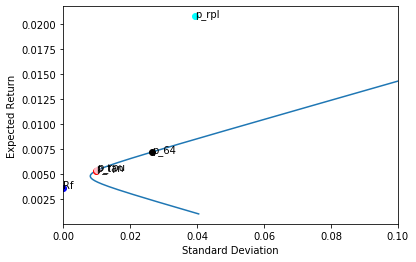

In [42]:
# plot

#frontier
mu_theoretical = np.linspace(0.001,0.015,1000)
A = np.ones(2).T.dot(np.linalg.inv(sigma)).dot(np.ones(2))
B = np.ones(2).T.dot(np.linalg.inv(sigma)).dot(mu)
C = mu.T.dot(np.linalg.inv(sigma)).dot(mu)
delta = A*C - B**2

#sigma of the tangency portfolio corresponding to each mu
sig_tan = np.sqrt((A*np.multiply(mu_theoretical,mu_theoretical)-2*B*mu_theoretical+C)/delta) 

plt.plot(sig_tan, mu_theoretical)
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.xlim(0, 0.1)

portfolios = ["p_tan", "p_64", "p_rpl", "p_rpu"]
all_means = summ_1[portfolios].loc["mean_ret"].values
all_stds = summ_1[portfolios].loc["std_ret"].values
colors = ["red", "black", "cyan", "pink"]
for i in range(len(all_means)):
    plt.plot(all_stds[i], all_means[i], c=colors[i], marker="o")
    plt.annotate(portfolios[i], xy=(all_stds[i], all_means[i]))

plt.plot(0.0, np.mean(data["simp_ret"]), "bo")
plt.annotate("Rf", xy=(0,np.mean(data["simp_ret"])))

#### 2.7. Risk parity rolling


In [173]:
# Following the notes of figure 1 in AFP (or of table 2 in AFP), note that their RP-
# strategy is actually computed by rebalancing the portfolio at every month setting
# the weights in each asset class equal to the inverse of its volatility, estimated
# by using three-year monthly excess returns up to month t − 1. Compute the
# returns to this ”rolling-window” RP-strategy. Choose portfolio weights again
# such that the portfolio’s full sample volatility is equal to the volatility of the
# 60/40 portfolio. Also compute the RP-unlevered strategy returns following AFP.
# How do the performances of these ”rolling-window” RP strategies compare with
# that of the ”full-window” strategies you estimated previously? Are they identical?
# Why?

# three year monthly access = 12 x 3 - 1 rolling window
# extract relevant columns
rets = data[["date_x", "ret_x", "ret_y", "simp_ret"]].set_index("date_x")
rolling_mean = rets.rolling(window=12*3).mean().dropna()
rolling_std = rets[["ret_x","ret_y"]].rolling(window=12*3).std().dropna()
rolling_cov = rets[["ret_x","ret_y"]].rolling(window=12*3).cov().dropna()

# tangency portfolio, 60/40 portfolio and risk-parity-(un)levered portfolio

summ_dates= pd.DataFrame(columns=["p_tan", "p_64", "p_rpl", "p_rpu"], 
                      index=rolling_mean.index)

for date in rolling_mean.index:
    summ_2 = pd.DataFrame(columns=["p_tan", "p_64", "p_rpl", "p_rpu"], 
                      index=["mean_p", "std_p", "excess_ret", "sharpe_p"])

    sigma_p = np.array(rolling_cov.loc[date])
    mu_p = np.array(rolling_mean[["ret_x", "ret_y"]].loc[date])
    A = np.ones(2).T.dot(np.linalg.inv(sigma_p)).dot(np.ones(2))
    B = np.ones(2).T.dot(np.linalg.inv(sigma_p)).dot(mu_p)
    C = mu_p.T.dot(np.linalg.inv(sigma_p)).dot(mu_p)
    delta = A*C - B**2
    
    w_tan = (np.linalg.inv(sigma_p).dot(mu_p - rolling_mean.simp_ret[date]))/(B - A*rolling_mean.simp_ret[date])
    w_64 = np.array([0.6, 0.4])
    w_rpu = (1/rolling_std.loc[date])/(1/rolling_std.loc[date]).sum()
    std_64 = np.sqrt(w_64.T.dot(sigma_p).dot(w_64))
    w_rpl = std_64/rolling_std.loc[date]

    for p,w in {"p_tan": w_tan, "p_64": w_64, "p_rpl": w_rpl, "p_rpu": w_rpu}.items():
        ret_p = mu_p.T.dot(w)
        summ_dates[p][date] = ret_p   

In [194]:
mean_excess_ret_rolling = summ_dates.mean() - rolling_mean.simp_ret.mean()
tmp_dict = {"mean_ret": summ_dates.mean(), "std_ret": summ_dates.std(), "mean_excess_ret": mean_excess_ret_rolling,
           "sharpe_ratio": mean_excess_ret_rolling/summ_dates.std()}
summ_2 = pd.DataFrame(tmp_dict).T

In [195]:
summ_2

,p_tan,p_64,p_rpl,p_rpu
mean_ret,0.003802,0.007264,0.025256,0.005283
std_ret,0.016514,0.004267,0.010776,0.002913
mean_excess_ret,0.000080,0.003542,0.021535,0.001561
sharpe_ratio,0.004848,0.830083,1.998369,0.535954


#### 2.8. Utility of investor who chooses the rolling strategy

In [209]:
# Consider an investor who has mean-variance utility U = μ p − a 2 σ p 2 and a risk
# aversion coefficient a of 6. Using the full-sample estimates of the means and
# covariance matrix stocks and bonds, what is her optimal portfolio? What is its
# expected return, standard deviation, and Sharpe ratio of her optimal portfolio?
summ_utility = pd.DataFrame(index=summ_2.columns, columns=["utility"])
a = 6 # risk aversion(a/2)*vals["std_ret"]**2

for p,vals in summ_1[["p_tan", "p_64", "p_rpl", "p_rpu"]].iteritems():
    #print(vals)
    summ_utility.loc[p] = vals["mean_ret"] - (a/2)*vals["std_ret"]**2

In [210]:
summ_utility

,utility
p_tan,0.00502328
p_64,0.00508977
p_rpl,0.0161769
p_rpu,0.00506528


In [80]:
# • If the mean-variance investor could in addition invest in either the ”full-window”
# to transform them into simple and monthly rates, in order to use them in your portfolio construction (the
# stock returns are already simple monthly returns).
# RP strategy or the ”rolling-window” RP strategy, would she want to do so? Ex-
# plain what is AFP’s argument why risk-parity is actually a useful strategy.